# Test Luci's Implementation: recover_dynamics() and latent_time()

This notebook tests **only Luci's parts** (recover_dynamics and latent_time) while using scvelo/scanpy for other components.

In [79]:
from cellrank.datasets import bone_marrow
import matplotlib.pyplot as plt
import scanpy as sc
import scvelo as scv

# Import Luci's functions from project.tools
from project.tools import recover_dynamics, latent_time

In [80]:
adata = bone_marrow()
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

In [65]:
adata.shape

(5780, 27876)

## Preprocessing using scvelo/scanpy (NOT Luci's part)

In [81]:
# Use scvelo's preprocessing instead of project.pp
scv.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=True
)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 20068 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/Users/lucilu/miniconda3/envs/graphvelo/lib/python3.12/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## 🔴 TEST LUCI'S PART 1: recover_dynamics()

This tests Luci's implementation of `recover_dynamics()`

In [82]:
# Using Luci's recover_dynamics implementation
recover_dynamics(adata, n_jobs=-1)

recovering dynamics (using 10/10 cores)
    finished (0:00:52) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [83]:
# Verify that recover_dynamics produced the expected outputs
print("Checking outputs from recover_dynamics:")
print(f"  'fit_alpha' in adata.var: {'fit_alpha' in adata.var.columns}")
print(f"  'fit_beta' in adata.var: {'fit_beta' in adata.var.columns}")
print(f"  'fit_gamma' in adata.var: {'fit_gamma' in adata.var.columns}")
print(f"  'fit_t_' in adata.var: {'fit_t_' in adata.var.columns}")
print(f"  'fit_likelihood' in adata.var: {'fit_likelihood' in adata.var.columns}")
print(f"  'fit_t' in adata.layers: {'fit_t' in adata.layers.keys()}")
print(f"\nNumber of genes with successful fits: {adata.var['fit_alpha'].notna().sum()}")

Checking outputs from recover_dynamics:
  'fit_alpha' in adata.var: True
  'fit_beta' in adata.var: True
  'fit_gamma' in adata.var: True
  'fit_t_' in adata.var: True
  'fit_likelihood' in adata.var: True
  'fit_t' in adata.layers: True

Number of genes with successful fits: 588


## Velocity computation using scvelo (NOT Luci's part)

In [84]:
# Use scvelo's velocity instead of project.tl.velocity
scv.tl.velocity(adata, mode="dynamical")

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## 🔴 TEST LUCI'S PART 2: latent_time()

This tests Luci's implementation of `latent_time()`

In [ ]:
# Using Luci's latent_time implementation
latent_time(adata)
#scv.tl.latent_time(adata)

computing velocity graph (using 1/10 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [74]:
# Verify that latent_time produced the expected output
print("Checking outputs from latent_time:")
print(f"  'latent_time' in adata.obs: {'latent_time' in adata.obs.columns}")
print(f"\nLatent time statistics:")
print(adata.obs['latent_time'].describe())

Checking outputs from latent_time:
  'latent_time' in adata.obs: True

Latent time statistics:
count    5780.000000
mean        0.352687
std         0.254034
min         0.000000
25%         0.140339
50%         0.321482
75%         0.464872
max         1.000000
Name: latent_time, dtype: float64


## Visualization using scvelo (NOT Luci's part)

computing velocity graph (using 1/10 cores)
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


/Users/lucilu/miniconda3/envs/graphvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/lucilu/miniconda3/envs/graphvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


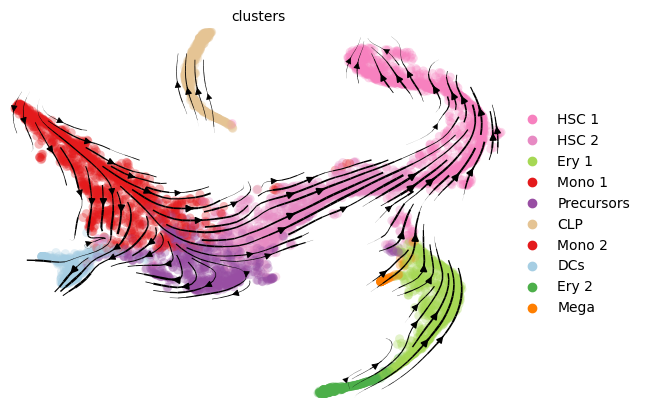

In [75]:
# Use scvelo for velocity graph and visualization
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='tsne', color='clusters', legend_loc='right', dpi=100)

## Check top velocity genes

In [76]:
genes = adata.var["fit_likelihood"].sort_values(ascending=False)[:2].index.to_list()
print(f"Top 2 genes by likelihood: {genes}")

Top 2 genes by likelihood: ['DNTT', 'ARPP21']


/Users/lucilu/miniconda3/envs/graphvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/lucilu/miniconda3/envs/graphvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


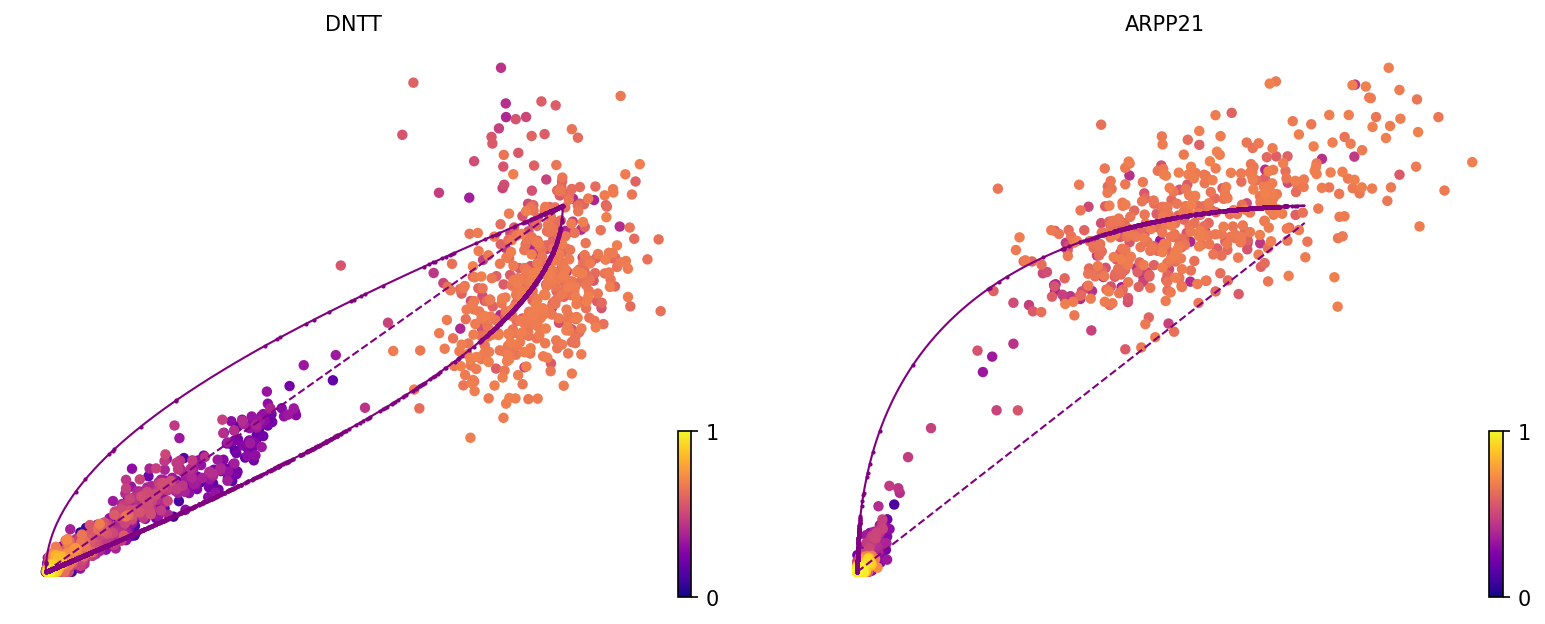

In [43]:
scv.pl.scatter(
    adata, 
    basis=genes, 
    color='palantir_pseudotime', 
    color_map='plasma',
    frameon=False,
    s=100,
    dpi=150
)

## Compare with scvelo's latent_time (Optional)

To verify Luci's implementation is working correctly, we can compare with scvelo's version.

computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Correlation between Luci's and scvelo's latent_time: 1.0000


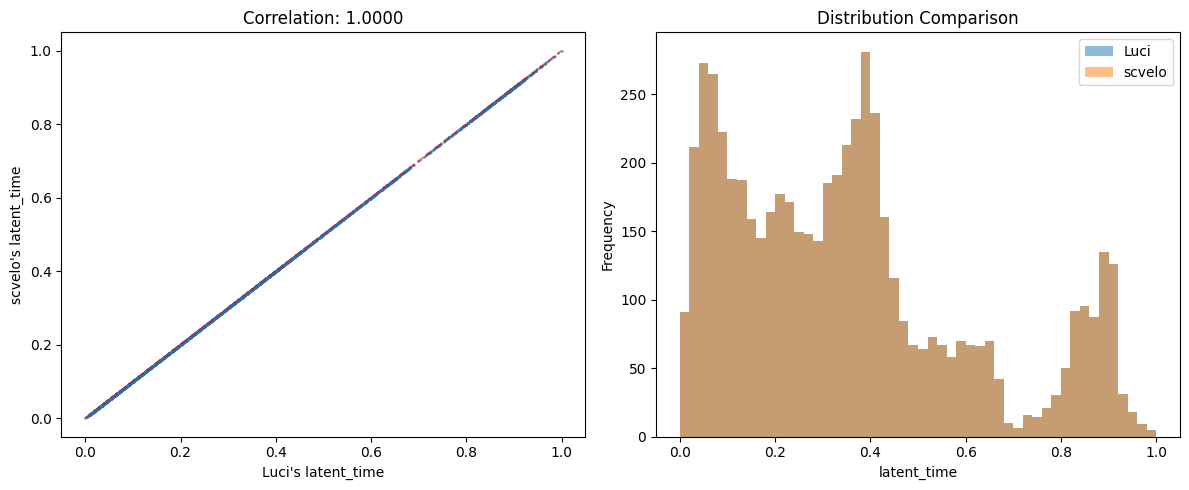

In [77]:
# Save Luci's result
luci_latent_time = adata.obs['latent_time'].copy()

# Run scvelo's version
scv.tl.latent_time(adata)
scvelo_latent_time = adata.obs['latent_time'].copy()

# Compare
import numpy as np
correlation = np.corrcoef(luci_latent_time, scvelo_latent_time)[0, 1]
print(f"Correlation between Luci's and scvelo's latent_time: {correlation:.4f}")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(luci_latent_time, scvelo_latent_time, alpha=0.5, s=1)
axes[0].set_xlabel("Luci's latent_time")
axes[0].set_ylabel("scvelo's latent_time")
axes[0].set_title(f"Correlation: {correlation:.4f}")
axes[0].plot([0, 1], [0, 1], 'r--', alpha=0.5)

axes[1].hist(luci_latent_time, bins=50, alpha=0.5, label="Luci")
axes[1].hist(scvelo_latent_time, bins=50, alpha=0.5, label="scvelo")
axes[1].set_xlabel("latent_time")
axes[1].set_ylabel("Frequency")
axes[1].legend()
axes[1].set_title("Distribution Comparison")

plt.tight_layout()
plt.show()

## Summary

This notebook tested:
- ✅ Luci's `recover_dynamics()` - recovers kinetic parameters from gene expression dynamics
- ✅ Luci's `latent_time()` - computes shared latent time across genes

All other functions (preprocessing, velocity computation, visualization) use scvelo/scanpy implementations.